# Lab 2: Frozen Lake
In this semester's lab on reinforcement learning, we will be using the [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) environment. The Frozen Lake environment is a classic reinforcement learning problem commonly used for teaching and experimenting with RL algorithms. It is part of the [OpenAI Gym library](https://gymnasium.farama.org/) and is modeled after the grid world problem.

In this environment, we need to start from a fixed point and bypass the ice holes we may encounter in order to reach the fixed end point and get the gift. At each position, we have four actions that can be performed next: walk up, walk down, walk left and walk right. If we fall into an ice hole, then the *current* round is over; on the other hand, if we reach the end, we will get one reward point.

**Submission Requirement:**
1. Finish all the TODO parts.
2. A written report including your understanding, comments, descriptions, thoughts ... for all the code snippets in this notebook should be also submitted to D2L in digital format (e.g., .pdf).

## Environment Setup

In [1]:
import os
# You will need numpy and gym. You can try running the following lines to install them
# The assignment is tested on Python3.8 so in case you are having installation issues you might
# want to try installing that version.

!{os.sys.executable} -m pip install numpy
!{os.sys.executable} -m pip install gymnasium
!{os.sys.executable} -m pip install Pillow
!{os.sys.executable} -m pip install ipython
!{os.sys.executable} -m pip install pygame

import gymnasium as gym
import numpy as np
import random
from PIL import Image
from IPython.display import display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.4 MB/s eta 0:00:00


## Part 1: Introduction to Frozen Lake
This part will introduce the basic setup and control methods of Frozen Lake, including two tasks to help you get started quickly.

In [2]:
# Import the environment we will use in this assignment
env=gym.make('FrozenLake-v1',is_slippery=False, render_mode="rgb_array").unwrapped

# Show the model
print(f"Number of States {env.observation_space.n}, Number of Actions {env.action_space.n}")
print(f"Reward range {env.reward_range}")

Number of States 16, Number of Actions 4
Reward range (0, 1)


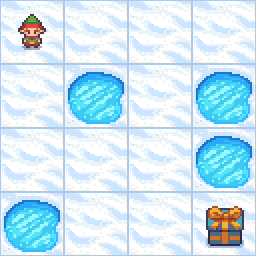

In [6]:
# reset the environment
env.reset()
# visualize the current state
display(Image.fromarray(env.render()))

Here is the mapping between actions and indices:
```
0: Move left
1: Move down
2: Move right
3: Move up
```
The following are two examples to help you get familiar with the environment. There is no task you need to finish in examples.
### Example 1
This is an example showing how to control the player to walk in a given direction. Be sure to reset the environment before starting a new round to ensure starting from the initial position.

state index= 4 reward= 0.0 is_finished= False
state index= 8 reward= 0.0 is_finished= False


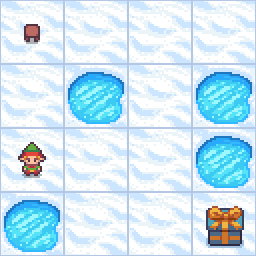

In [7]:
env.reset()
action_1 = 1 # move down
state, reward, finished, _, _ = env.step(action_1) # input the action instruction to env
print("state index=", state, "reward=", reward, "is_finished=", finished)

action_2 = 1 # move down again
state, reward, finished, _, _ = env.step(action_2) # input the action instruction to env
print("state index=", state, "reward=", reward, "is_finished=", finished)

# display the environment state
display(Image.fromarray(env.render()))

This is another example showing what happens if the player falls into an ice hole. In this example, we'll take advantage of Python's ability to use foor loops to perform actions sequentially.

In [ ]:
env.reset()
actions = [
    2, # move right
    2, # move right
    2, # move right
    1, # move down
]
for action in actions:
  state, reward, finished, _, _ = env.step(action) # input the action instruction to env
  print("state index=", state, "reward=", reward, "is_finished=", finished)
# display the env state
display(Image.fromarray(env.render()))

### Task 1: Navigate to the end
Now it's your turn to avoid all the ice holes and get the gift. You only need to give one path to reach the end. Don't forget to **reset the environment before everything starts**!

In [ ]:
#################TODO#####################

#############################################
display(Image.fromarray(env.render()))

### Task 2: Sliding on the ice
In a more complex setting, we introduce the concept of slippery. This means that there is only a 1/3 probability that you will move in your specified direction, and a 1/3 probability that you will slide vertically up or down, respectively. For example, if you want to walk to the right, then
```
P(move right) = 1/3
P(move up) = 1/3
P(move down) = 1/3
```
In this task, you need to re-execute the actions in Task 1 to see if you can still end up with the gift. You **don't have to get the gift**, but we expect you to be aware of the effect of randomness on the policy (i.e., action plan).


In [ ]:
# load the environmet in new setting
env=gym.make('FrozenLake-v1',is_slippery=True, render_mode="rgb_array").unwrapped
#################TODO#####################

#############################################
display(Image.fromarray(env.render()))

## Part 2: MDP and Policy Iteration
From now on, we will focus on considering the sliding environment setting, as it is more in line with what we study in reinforcement learning.
### Environment Model
The environment model is a command for retrieving the current state of the environment, which can help us in constructing the MDP algorithm. This command contains two parameters State and Action:
1. State refers to the index of a specific position in the environment. For example, for a fixed 4*4 map, the top row has positions indexed 0, 1, 2, 3, where the index of the top-left start position is 0, and the bottom row has positions 12, 13, 14, 15, where the index of the end position is 15.
2. Action here refers to the index 0-3 of the movement we mentioned in the previous part.

Given the current position STATE and the next action ACTION, we can obtain the environment model very easily via
```
env.P[STATE][ACTION]
```
The return value includes a list of tuples, where each tuple contains four values: probability, the new position after moving, the reward, and whether the episode has ended. Following is an example, you may need to run this ceil several times to see what happens when you slip and don't slip.

In [ ]:
# try to run several times to see the difference between slippery and non-slippery
env=gym.make('FrozenLake-v1',is_slippery=True, render_mode="rgb_array").unwrapped
env.reset()
random_state  = env.observation_space.sample()
random_action = env.action_space.sample()
print("Position index=", random_state)
print("Action index=", random_action)
# returns a list of tuples (probability,newstate,reward,is_terminal_state)
env.P[random_state][random_action]

### Task 1: Implement Policy Evaluation
In this task you need to complete the `policy_evaluation` function, which iteratively update the value of each state according to the policy until the value function converges.
<div>
    <img src="https://github.com/Michigan-State-University-CSE-440/Frozen-Lake-and-MDP/blob/main/assets/policy_eva.png?raw=1" alt="Description" width="800" height="150">
</div>

#### Step-by-Step Implementation Instructions

1. **For each iteration**:
   - Create a new array to store updated values for all states (e.g., `new_value_function`).
   - For each state `s`, look up the policy’s action `a`. Use the environment model `P[s][a]` to:
     - Calculate the expected return by summing over all transitions `(prob, next_state, reward, done)`.
     - Write this computed value into `new_value_function[s]`.
   - Compare `new_value_function` to your current `value_function` and record the largest change (`delta`).
   - Assign `value_function = new_value_function` for the next iteration.

2. **Stop** when the largest change (`delta`) falls below the specified tolerance (`tol`).

By doing this, the function will evaluate how good the policy is (i.e., compute a stable estimate of the return from each state).

In [ ]:
def policy_evaluation(P, nS, policy, gamma=0.9, tol=1e-3):
    """
    Evaluate the value function from a given policy.

    Parameters
    ----------
    P : Environment model where:
        P[0]: Probability of transitioning from state s to next_state using action a.
        P[1]: The next state after taking action a.
        P[2]: The immediate reward for this transition.
        P[3]: A boolean that indicates if the next_state is terminal.
    nS : int
        The number of states in the environment.
    policy : np.ndarray of shape [nS]
        The policy to evaluate. Maps each state s to the action a that should be taken.
    gamma : float, optional (default=0.9)
        The discount factor, must be in the range [0,1).
        Higher gamma discounts future rewards more slowly.
    tol : float, optional (default=1e-3)
        Tolerance for convergence of the value function. The evaluation stops when
        max |new_value_function[s] - value_function[s]| < tol.

    Returns
    -------
    value_function : np.ndarray of shape [nS]
        The value function for the given policy. value_function[s] gives the expected
        return (discounted sum of future rewards) when starting from state s and
        following the given policy forever.
    """
    # Initialize the value function with zeros
    value_function = np.zeros(nS)
    while True:
        delta = 0
        ######################TODO#######################

        #################################################

    return value_function

Test your policy_evaluation on 5 randomly generated deterministic policies

In [ ]:
# evaluate random policy
n_state = env.observation_space.n
for i in range(5):
   random_policy = np.random.randint(4, size=n_state)
   print(f'-------- Policy {i}','-'*30)
   print(policy_evaluation(P=env.P, nS=n_state, policy=random_policy))

### Task 2: Implement Policy Improvement
In this task, you need to complete the `policy_improvement` function so that it uses **one-step look-ahead** to compute a better policy, given a value function `value_from_policy`.

Below is the equation we learned in class (represented as an image):

<div>
    <img src="https://github.com/Michigan-State-University-CSE-440/Frozen-Lake-and-MDP/blob/main/assets/policy_imp.png?raw=1" alt="Description" width="800" height="150">
</div>

This can be broken down into the following steps:

1. **Compute `Q(s, a)` for each action**.  
2. **Find the action** \(a\) **that maximizes** `Q(s, a)` and **set** `new_policy[s]` to that action.

#### Step‐by‐Step Implementation Instructions

1. **Loop over all states** `s` in `range(nS)`.
2. **For each state** `s`, **loop over all actions** `a` in `range(nA)`.
3. **Compute** `Q(s, a)` by summing:  
   ```
   prob * (reward + gamma * value_from_policy[next_state])
   for each `(prob, next_state, reward, done)` in `P[s][a]`.
   ```
4. **Keep track** of which `a` produces the largest `Q(s, a)` value and store this action in `new_policy[s]`.
5. **Return** `new_policy` at the end.

**Hint:** Initialize a variable like `best_q = float('-inf')` (negative infinity) before checking which action gives the highest `Q(s, a)`. This ensures you can handle negative values if needed.

When you finish, your `policy_improvement` function will pick the **best action** in each state, given the value function `value`.

In [ ]:
def policy_improvement(P, nS, nA, value, gamma=0.9):
    """
    Given the value function V(s) from a policy π, improve the policy by taking a one-step look-ahead
    and choosing the action that maximizes expected return.

    The one-step look-ahead uses:
        π_{new}(s) = arg max_a  ∑_{s'}  P(s'|s,a) [ R(s,a,s') + γ * V(s') ]

    Parameters
    ----------
    P : Environment model where:
        P[0]: Probability of transitioning from state s to next_state using action a.
        P[1]: The next state after taking action a.
        P[2]: The immediate reward for this transition.
        P[3]: A boolean that indicates if the next_state is terminal.
    nS : int
        Number of states in the environment.
    nA : int
        Number of actions in the environment.
    value : np.ndarray of shape [nS]
        The value function V(s) computed from the current policy π.
    gamma : float, optional (default=0.9)
        Discount factor, must be in [0,1). High γ puts more weight on future rewards.

    Returns
    -------
    new_policy : np.ndarray of shape [nS]
        The *improved* policy, where new_policy[s] is the action that maximizes the
        one-step look-ahead given value_from_policy.
    """

    # Initialize the new policy array
    new_policy = np.zeros(nS, dtype=int)
    ###################TODO#####################

    ############################################
    return new_policy

Print the value before and after policy improvements for 5 randomly generated policies

In [ ]:
n_state = env.observation_space.n
for i in range(5):
   random_policy = np.random.randint(4, size=n_state)
   print(f'-------- Policy {i}','-'*30)
   pre_value_func = policy_evaluation(env.P, n_state, random_policy)
   print(pre_value_func) # Print value function before improvement

   print(f'-------> Policy {i} IMPROVED','-'*21)
   improved_policy = policy_improvement(env.P, n_state, env.action_space.n, pre_value_func)
   imp_value_func = policy_evaluation(env.P, n_state, improved_policy)
   print(imp_value_func) # Print value after improvement

### Policy Iteration
This `policy_iteration` function calls the `policy_evaluation` and `policy_improvement` functions to implement the full policy iteration algorithm. **There is no TODO part in this function.** You only need to run it after understanding how it works.

#### Function Interpretation
1. **Policy Evaluation**:
   - Call `policy_evaluation(P, nS, nA, policy, gamma, tol)` to compute the value function under the **current** policy.

2. **Policy Improvement**:
   - Call `policy_improvement(P, nS, nA, value_function, policy, gamma)` to get a **new** policy that improves upon the current one.

3. **Check for Policy Stability**:
   - Compare the new policy with the old policy. If they are the **same** for all states, the policy is stable and you can **break** out of the loop.
   - Otherwise, set the current policy to the new policy and **continue** iterating.

4. **Result**:
   - By the end of this process, you should have a **stable** policy that *cannot* be improved further with respect to the environment model `P`.

In [ ]:
def policy_iteration(P, nS, nA, gamma=0.9, tol=1e-3):
    """
    Run policy iteration for dynamics of P.

    You should use your methods: policy_evaluation() and policy_improvement() here

    Parameters:
    P, nS, nA, gamma: defined at beginning of file
    tolerance:        tolerance parameter used in policy_evaluation()

    Returns:
    value_function: np.ndarray[nS]
    policy:         np.ndarray[nS]
    """
    value_function = np.zeros(nS)
    policy = np.zeros(nS, dtype=int)
    while(True):
      value_function = policy_evaluation(P, nS, policy, gamma, tol)
      new_policy = policy_improvement(P, nS, nA, value_function, gamma)

      policy_stable = True
      for i in range(len(policy)):
        if new_policy[i] != policy[i]:
          policy_stable = False
          break
      if policy_stable is True:
        break
      else:
        policy = new_policy

    return value_function, policy

### Task 3: Call Policy Iteration and Do Evaluation
In this task, first you need to set the gamma value and call the `policy_iteration` function to get the optimal policy. Then you need to call the `follow_policy` function to test your policy and see the results.

**Hint:**  
- You need to **try different gamma values** to finsh the following task 4.
- Try again if you cannot reach the end point using the strategy generated by the `policy_iteration` function, which is due to the randomness of state transitions. Usually it only takes two or three tries to succeed. If it never works, you probably did not complete the `policy_evaluation` or (and) `policy_improvement` functions correctly.

In [ ]:
tolerance = 0.001
##############################TODO##############################
gamma =
value, policy =
################################################################
print("Value Function:", value)
print("Policy:", policy)

In [ ]:
def follow_policy(policy):
    """
    Follows the given policy from start (state 0) to goal (state 15).

    Parameters:
    policy (list): The policy array where each index represents the state and
                   the value represents the action (0=Left, 1=Down, 2=Right, 3=Up).

    Returns:
    actions (list): The sequence of actions taken.
    env (object): The environment object.
    """

    # Start at state 0 (top-left corner)
    state = 0
    done = False
    actions_taken = []  # Track actions
    env.reset()
    while done == False:
        action = policy[state]  # Get action from policy
        actions_taken.append(action)
        # Take action and observe new state
        state, _, done, _, _ = env.step(action)

    return actions_taken, env

In [ ]:
actions, states = follow_policy(policy)
print("Actions Taken:", actions)
display(Image.fromarray(states.render()))

### Task 4 (Written Question):
**Question**: After experimenting with various `gamma` values, what impact did you observe on the policy?

##############################TODO##############################  

**Answer:**

################################################################